# Análisis de tweets sobre MENAs

# Librerías necesarias

In [ ]:
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=934244fc69e8a611d707a4591be210feb3bac20ebf9a7bc9065e9fe03f5dbb1e
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1127937 sha256=4845de601ffebff0b023dc0ff8516338dadf2d3232c3c88e8df304ba4d1a5bef
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Epoch: 001, Loss: 6.4256, Train: 0.3363, Val: 0.3001, Test: 0.3413
Epoch: 002, Loss: 5.7757, Train: 0.3883, Val: 0.3589, Test: 0.3904
Epoch: 003, Loss: 2.0248, Train: 0.4556, Val: 0.4442, Test: 0.4515
Epoch: 004, Loss: 1.2320, Train: 0.5264, Val: 0.5126, Test: 0.5269
Epoch: 005, Loss: 0.6228, Train: 0.6858, Val: 0.6831, Test: 0.6862
Epoch: 006, Loss: 0.4884, Train: 0.9630, Val: 0.9676, Test: 0.9641
Epoch: 007, Loss: 0.6841, Train: 0.9797, Val: 0.9892, Test: 0.9772
Epoch: 008, Loss: 0.6784, Train: 0.9799, Val: 0.9892, Test: 0.9772
Epoch: 009, Loss: 0.5972, Train: 0.9799, Val: 0.9892, Test: 0.9772
Epoch: 010, Loss: 0.4342, Train: 0.9799, Val: 0.9892, Test: 0.9772
Final Test Accuracy: 0.9772


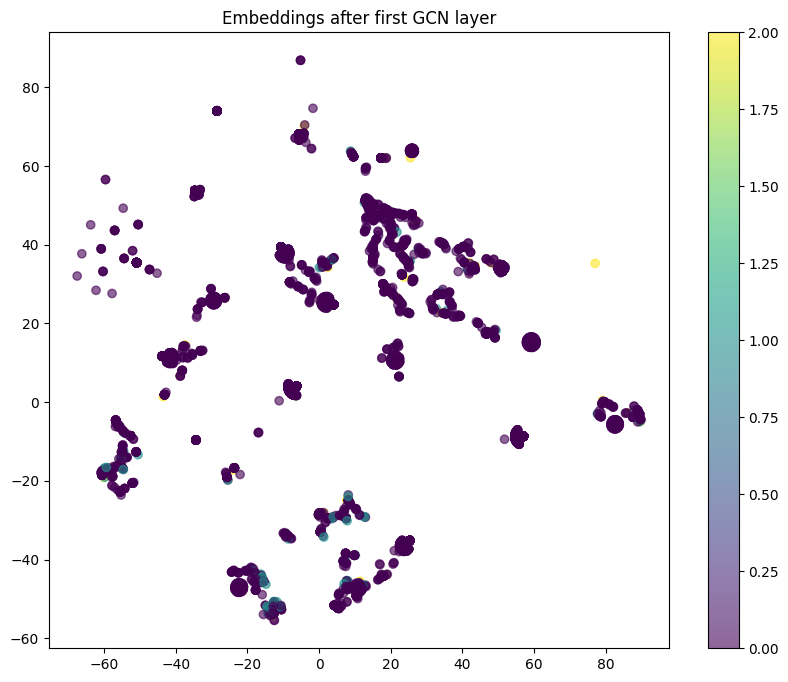

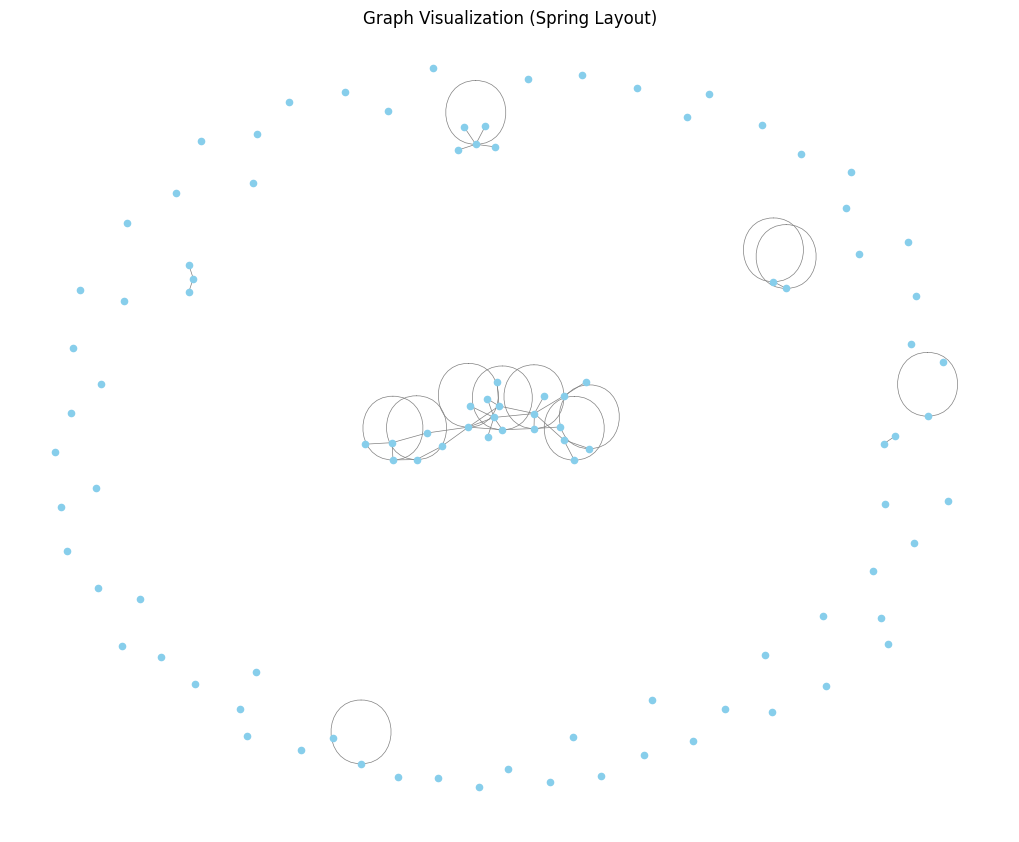

In [ ]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np

from google.colab import drive

# 1. Carga y preprocesamiento de datos
drive.mount('/content/drive')
dataset_df = pd.read_excel('/content/drive/MyDrive/Profundo/Retweets menas.xlsx')

# Preprocesamiento
source_col = 'Nombre de usuario'
target_col = 'Retwiteado por'
feature_cols = ['Cantidad de retweets', 'Cantidad de tweets', 'Cantidad de seguidores', 'Cantidad de Siguiendo']

# Limpieza de datos
dataset_df = dataset_df.dropna(subset=[source_col, target_col])  # Eliminar filas con valores nulos
dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)    # Rellenar otros valores nulos con 0

# Mapeo de nodos a IDs numéricos
all_nodes = pd.unique(dataset_df[[source_col, target_col]].values.ravel('K'))
node_to_id = {node: i for i, node in enumerate(all_nodes)}

dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
dataset_df[target_col] = dataset_df[target_col].map(node_to_id)

# Crear edge_index (asegurarse de que los índices estén en el rango correcto)
edge_index = torch.tensor(dataset_df[[source_col, target_col]].values.T, dtype=torch.long)

# Verificar que todos los índices estén dentro del rango
assert edge_index.min() >= 0
assert edge_index.max() < len(all_nodes)

# Crear características (x) - normalizar
# Necesitamos una fila por nodo, no por arista
num_nodes = len(all_nodes)
x = torch.zeros((num_nodes, len(feature_cols)), dtype=torch.float)

# Asignar características a cada nodo (tomamos el primer valor encontrado para cada nodo)
# Iterate through the DataFrame instead of groupby
for index, row in dataset_df.iterrows():
    node_id = row[source_col]  # Get the numerical node ID directly
    # Convert all feature values to float before creating the tensor
    feature_values = [float(val) for val in row[feature_cols].values]
    x[node_id] = torch.tensor(feature_values, dtype=torch.float)

# Normalización
x = (x - x.mean(dim=0)) / x.std(dim=0)

# Crear etiquetas (y) - en este caso usaremos los grados de los nodos como ejemplo
# Esto evita problemas con etiquetas fuera de rango
degrees = torch.zeros(num_nodes, dtype=torch.long)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1

# Convertir grados a clases (por ejemplo, 0: bajo, 1: medio, 2: alto)
y = torch.bucketize(degrees, boundaries=torch.tensor([5, 20]))  # Ajustar estos valores según tu dataset
num_classes = len(torch.unique(y))

# Creación del objeto Data de PyTorch Geometric
data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes
data.num_nodes = num_nodes

# Creación de máscaras de entrenamiento, validación y prueba
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

indices = torch.randperm(num_nodes)
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:train_end]] = True
data.val_mask[indices[train_end:val_end]] = True
data.test_mask[indices[val_end:]] = True

# 2. Definición del modelo
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Entrenamiento (primero en CPU para depuración)
device = torch.device('cpu')  # Empezamos en CPU para depuración
print(f"Using device: {device}")

model = GCN(data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    # Check for NaN or infinite values in the output
    if torch.isnan(out).any() or torch.isinf(out).any():
        print("NaN or Inf values detected in model output. Check your data or model.")
        return None  # or raise an exception to stop execution
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

# Entrenamiento inicial en CPU
for epoch in range(1, 11):  # Solo 10 épocas para prueba
    loss = train()
    # Skip the rest of the epoch if loss is None (indicating an error)
    if loss is None:
        continue
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# Si funciona en CPU, podemos intentar con GPU
if torch.cuda.is_available():
    print("\nMoving to GPU...")
    device = torch.device('cuda')
    model = model.to(device)
    data = data.to(device)

    for epoch in range(11, 201):
        loss = train()
        if epoch % 20 == 0:
            train_acc, val_acc, test_acc = test()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# 4. Evaluación final
model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = test_correct / data.test_mask.sum().item()
    print(f'Final Test Accuracy: {test_acc:.4f}')

# 5. Visualización
def visualize_embeddings(embeddings, labels, title):
    embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Obtener embeddings del modelo
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

visualize_embeddings(embeddings, data.y.cpu().numpy(), 'Embeddings after first GCN layer')

# Visualización del grafo (versión simplificada)
def visualize_graph(graph, layout_func, title, ax=None):
    pos = layout_func(graph)
    nx.draw(graph, pos=pos, with_labels=False, node_size=20, node_color='skyblue',
            edge_color='gray', width=0.5, ax=ax)
    plt.title(title)

# Crear un subgrafo más pequeño para visualización
graph = to_networkx(data, to_undirected=True)
sampled_nodes = list(graph.nodes)[:100]  # Tomar solo 100 nodos para visualización
subgraph = graph.subgraph(sampled_nodes)

plt.figure(figsize=(10, 8))
visualize_graph(subgraph, nx.spring_layout, 'Graph Visualization (Spring Layout)')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Epoch: 001, Loss: 2.1650, Train: 0.4587, Val: 0.4502, Test: 0.4455
Epoch: 002, Loss: 4.6895, Train: 0.5770, Val: 0.5630, Test: 0.5605
Epoch: 003, Loss: 4.6022, Train: 0.6891, Val: 0.6819, Test: 0.6707
Epoch: 004, Loss: 0.8098, Train: 0.9632, Val: 0.9556, Test: 0.9593
Epoch: 005, Loss: 1.0736, Train: 0.9810, Val: 0.9832, Test: 0.9784
Epoch: 006, Loss: 3.1483, Train: 0.9810, Val: 0.9832, Test: 0.9784
Epoch: 007, Loss: 0.3378, Train: 0.9810, Val: 0.9832, Test: 0.9784
Epoch: 008, Loss: 0.4808, Train: 0.9810, Val: 0.9832, Test: 0.9784
Epoch: 009, Loss: 0.3300, Train: 0.9810, Val: 0.9832, Test: 0.9784
Epoch: 010, Loss: 0.3473, Train: 0.9810, Val: 0.9832, Test: 0.9784
Final Test Accuracy: 0.9784


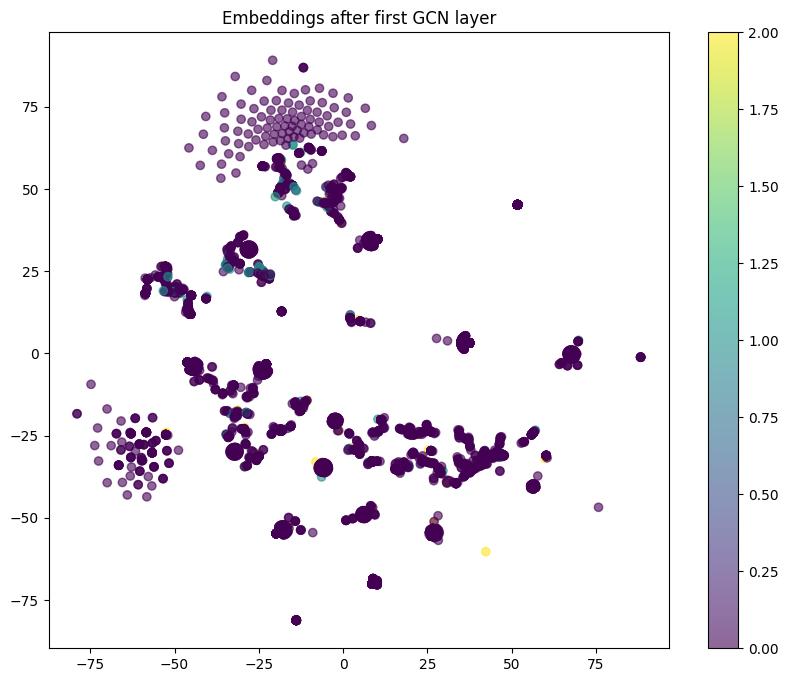

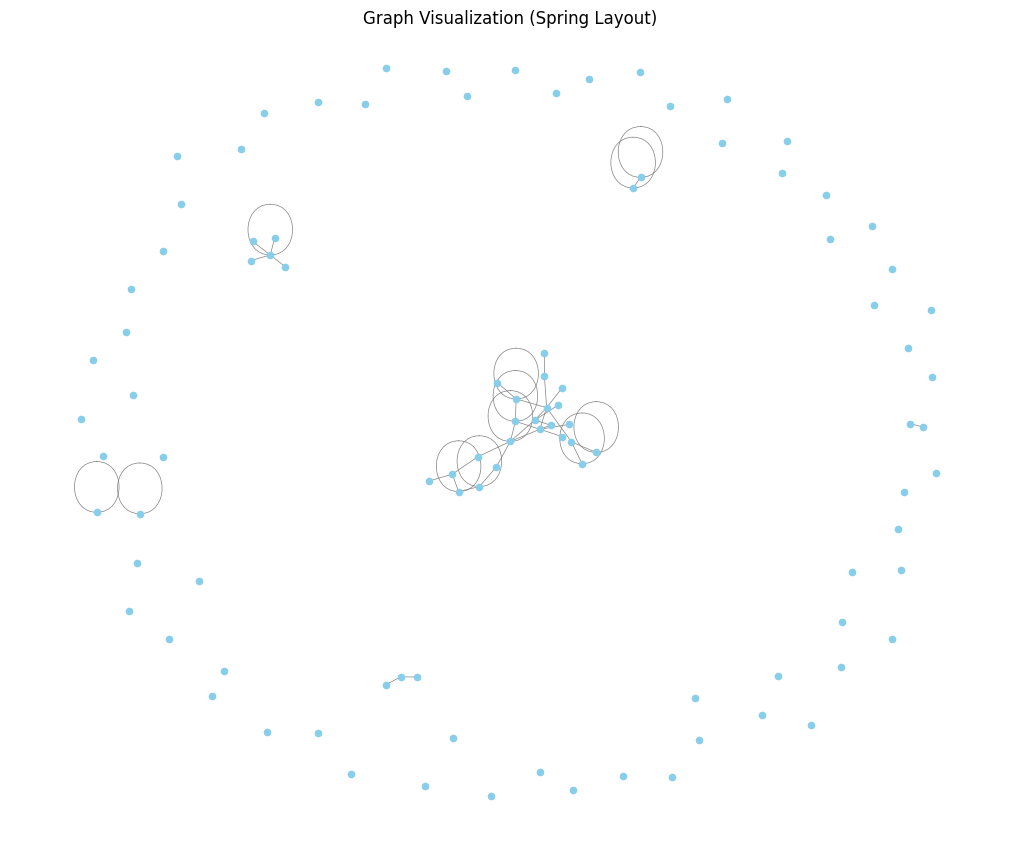

In [ ]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np

from google.colab import drive

# 1. Carga y preprocesamiento de datos
drive.mount('/content/drive')
dataset_df = pd.read_excel('/content/drive/MyDrive/Profundo/Retweets menas.xlsx')

# Preprocesamiento
source_col = 'Nombre de usuario'
target_col = 'Retwiteado por'
feature_cols = ['Cantidad de retweets', 'Cantidad de tweets', 'Cantidad de seguidores', 'Cantidad de Siguiendo']

# Limpieza de datos
dataset_df = dataset_df.dropna(subset=[source_col, target_col])
dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)

# Mapeo de nodos a IDs numéricos
all_nodes = pd.unique(dataset_df[[source_col, target_col]].values.ravel('K'))
node_to_id = {node: i for i, node in enumerate(all_nodes)}

dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
dataset_df[target_col] = dataset_df[target_col].map(node_to_id)

# Crear edge_index
edge_index = torch.tensor(dataset_df[[source_col, target_col]].values.T, dtype=torch.long)

# Verificar índices
assert edge_index.min() >= 0
assert edge_index.max() < len(all_nodes)

# Crear características (x)
num_nodes = len(all_nodes)
x = torch.zeros((num_nodes, len(feature_cols)), dtype=torch.float)

for index, row in dataset_df.iterrows():
    node_id = row[source_col]
    feature_values = [float(val) for val in row[feature_cols].values]
    x[node_id] = torch.tensor(feature_values, dtype=torch.float)

# Normalización
x = (x - x.mean(dim=0)) / x.std(dim=0)

# Crear etiquetas (y)
degrees = torch.zeros(num_nodes, dtype=torch.long)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1

y = torch.bucketize(degrees, boundaries=torch.tensor([5, 20]))
num_classes = len(torch.unique(y))

# Creación del objeto Data de PyTorch Geometric
data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes
data.num_nodes = num_nodes

# Creación de máscaras
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

indices = torch.randperm(num_nodes)
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:train_end]] = True
data.val_mask[indices[train_end:val_end]] = True
data.test_mask[indices[val_end:]] = True

# 2. Definición del modelo
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Entrenamiento (primero en CPU)
device = torch.device('cpu')
print(f"Using device: {device}")

model = GCN(data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    if torch.isnan(out).any() or torch.isinf(out).any():
        print("NaN or Inf values detected in model output. Check your data or model.")
        return None
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

for epoch in range(1, 11):
    loss = train()
    if loss is None:
        continue
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

if torch.cuda.is_available():
    print("\nMoving to GPU...")
    device = torch.device('cuda')
    model = model.to(device)
    data = data.to(device)

    for epoch in range(11, 201):
        loss = train()
        if epoch % 20 == 0:
            train_acc, val_acc, test_acc = test()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = test_correct / data.test_mask.sum().item()
    print(f'Final Test Accuracy: {test_acc:.4f}')

def visualize_embeddings(embeddings, labels, title):
    embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

visualize_embeddings(embeddings, data.y.cpu().numpy(), 'Embeddings after first GCN layer')

def visualize_graph(graph, layout_func, title, ax=None):
    pos = layout_func(graph)
    nx.draw(graph, pos=pos, with_labels=False, node_size=20, node_color='skyblue', edge_color='gray', width=0.5, ax=ax)
    plt.title(title)

graph = to_networkx(data, to_undirected=True)
sampled_nodes = list(graph.nodes)[:100]
subgraph = graph.subgraph(sampled_nodes)

plt.figure(figsize=(10, 8))
visualize_graph(subgraph, nx.spring_layout, 'Graph Visualization (Spring Layout)')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Epoch: 001, Loss: 7.9291, Train: 0.0165, Val: 0.0132, Test: 0.0204
Epoch: 002, Loss: 9.7475, Train: 0.0193, Val: 0.0168, Test: 0.0228
Epoch: 003, Loss: 6.4638, Train: 0.0242, Val: 0.0252, Test: 0.0240
Epoch: 004, Loss: 6.9554, Train: 0.0311, Val: 0.0372, Test: 0.0359
Epoch: 005, Loss: 3.5682, Train: 0.0432, Val: 0.0432, Test: 0.0455
Epoch: 006, Loss: 3.9531, Train: 0.1047, Val: 0.0924, Test: 0.1042
Epoch: 007, Loss: 2.0691, Train: 0.2103, Val: 0.2113, Test: 0.1916
Epoch: 008, Loss: 2.1141, Train: 0.2818, Val: 0.2773, Test: 0.2599
Epoch: 009, Loss: 1.9840, Train: 0.8359, Val: 0.8319, Test: 0.8419
Epoch: 010, Loss: 1.9802, Train: 0.9154, Val: 0.9040, Test: 0.9078
Final Test Accuracy: 0.9078


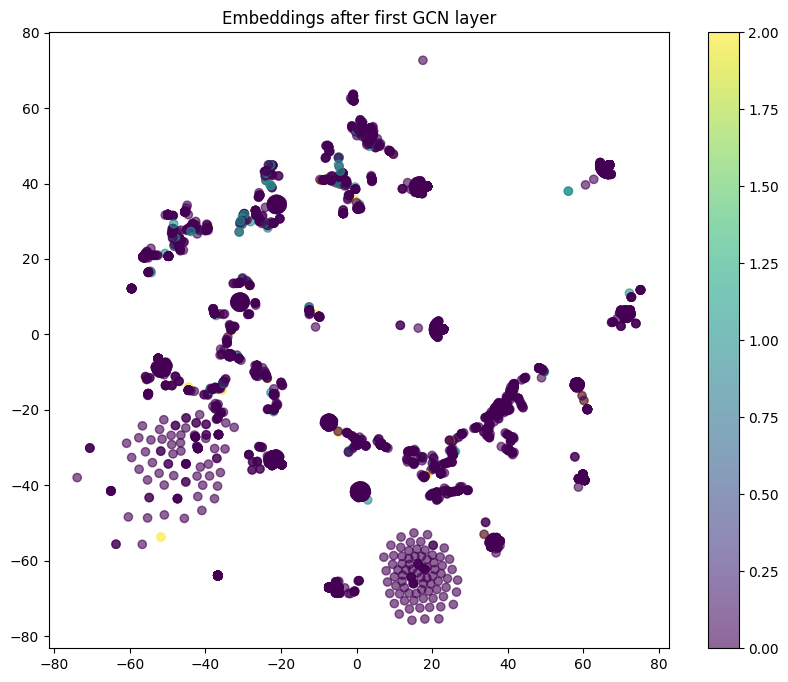

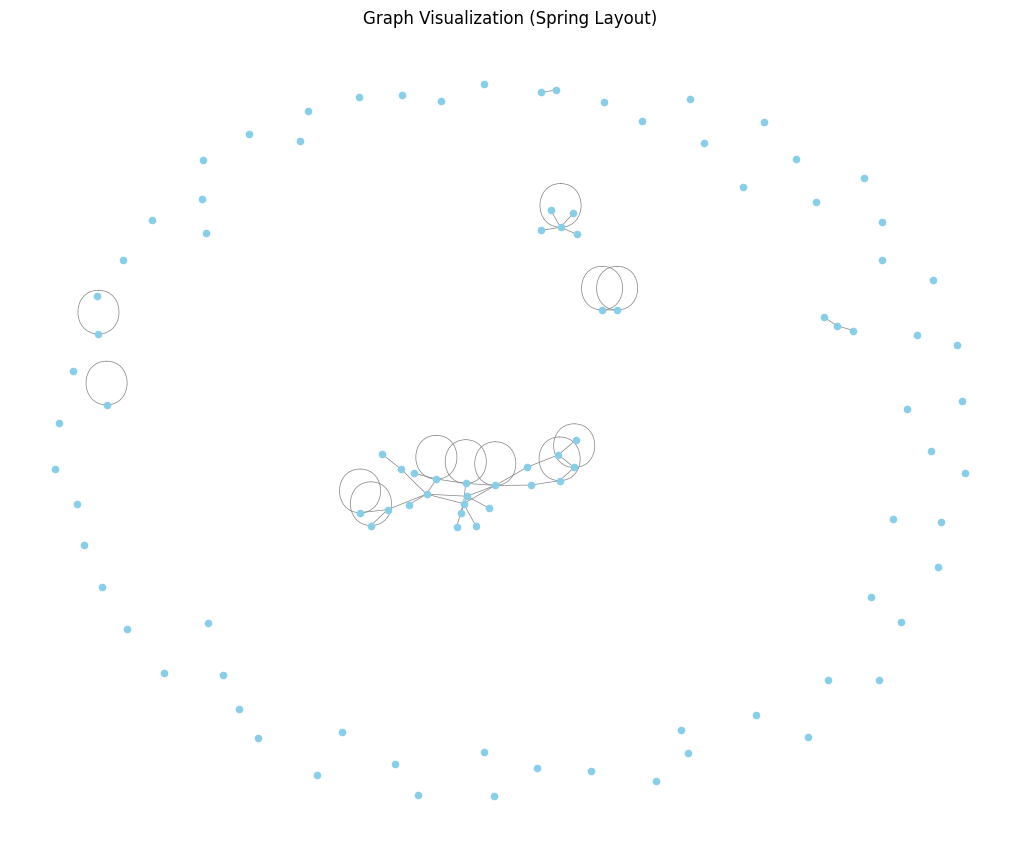

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from google.colab import drive

# 1. Carga y preprocesamiento de datos desde DataFrame
drive.mount('/content/drive')
dataset_df = pd.read_excel('/content/drive/MyDrive/Profundo/Retweets menas.xlsx')

source_col = 'Nombre de usuario'
target_col = 'Retwiteado por'
feature_cols = ['Cantidad de retweets', 'Cantidad de tweets', 'Cantidad de seguidores', 'Cantidad de Siguiendo']

dataset_df = dataset_df.dropna(subset=[source_col, target_col])
dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)

all_nodes = pd.unique(dataset_df[[source_col, target_col]].values.ravel('K'))
node_to_id = {node: i for i, node in enumerate(all_nodes)}

dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
dataset_df[target_col] = dataset_df[target_col].map(node_to_id)

edge_index = torch.tensor(dataset_df[[source_col, target_col]].values.T, dtype=torch.long)

assert edge_index.min() >= 0
assert edge_index.max() < len(all_nodes)

num_nodes = len(all_nodes)
x = torch.zeros((num_nodes, len(feature_cols)), dtype=torch.float)

for index, row in dataset_df.iterrows():
    node_id = row[source_col]
    feature_values = [float(val) for val in row[feature_cols].values]
    x[node_id] = torch.tensor(feature_values, dtype=torch.float)

x = (x - x.mean(dim=0)) / x.std(dim=0)

degrees = torch.zeros(num_nodes, dtype=torch.long)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1

y = torch.bucketize(degrees, boundaries=torch.tensor([5, 20]))
num_classes = len(torch.unique(y))

data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes
data.num_nodes = num_nodes

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

indices = torch.randperm(num_nodes)
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:train_end]] = True
data.val_mask[indices[train_end:val_end]] = True
data.test_mask[indices[val_end:]] = True

# 2. Definición del modelo
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Entrenamiento (primero en CPU)
device = torch.device('cpu')
print(f"Using device: {device}")

model = GCN(data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    if torch.isnan(out).any() or torch.isinf(out).any():
        print("NaN or Inf values detected in model output. Check your data or model.")
        return None
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

for epoch in range(1, 11):
    loss = train()
    if loss is None:
        continue
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

if torch.cuda.is_available():
    print("\nMoving to GPU...")
    device = torch.device('cuda')
    model = model.to(device)
    data = data.to(device)

    for epoch in range(11, 201):
        loss = train()
        if epoch % 20 == 0:
            train_acc, val_acc, test_acc = test()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = test_correct / data.test_mask.sum().item()
    print(f'Final Test Accuracy: {test_acc:.4f}')

def visualize_embeddings(embeddings, labels, title):
    embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

visualize_embeddings(embeddings, data.y.cpu().numpy(), 'Embeddings after first GCN layer')

def visualize_graph(graph, layout_func, title, ax=None):
    pos = layout_func(graph)
    nx.draw(graph, pos=pos, with_labels=False, node_size=20, node_color='skyblue', edge_color='gray', width=0.5, ax=ax)
    plt.title(title)

graph = to_networkx(data, to_undirected=True)
sampled_nodes = list(graph.nodes)[:100]
subgraph = graph.subgraph(sampled_nodes)

plt.figure(figsize=(10, 8))
visualize_graph(subgraph, nx.spring_layout, 'Graph Visualization (Spring Layout)')
plt.show()

# Visualización del grafo

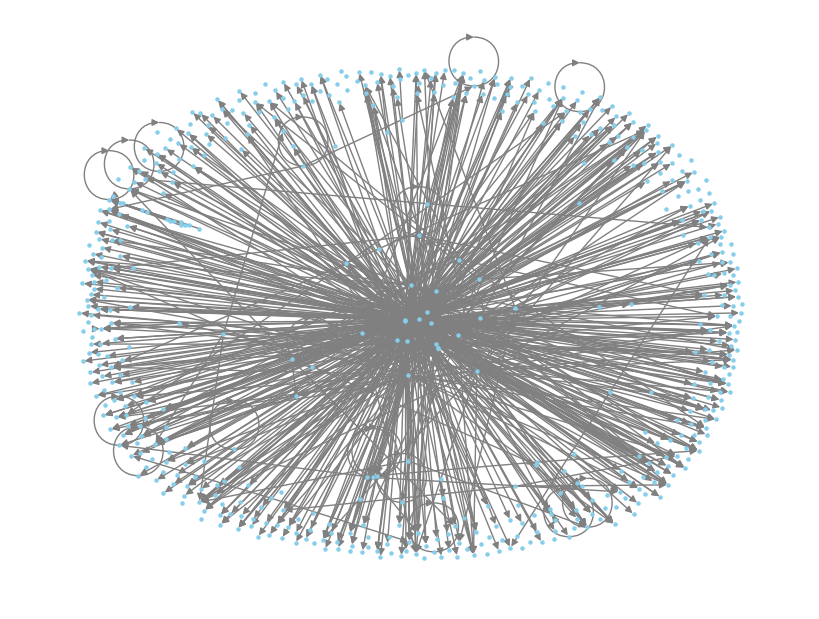

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Assuming 'data' is your PyTorch Geometric Data object created earlier
graph = to_networkx(data, to_undirected=False)  # Pass 'data' instead of 'df[0]'

# Optimization 1: Reduce the number of nodes and edges to be drawn

# You can sample a smaller subgraph for visualization to reduce drawing time
# For example, to randomly sample 10% of nodes:
num_nodes_to_sample = int(0.1 * graph.number_of_nodes())
sampled_nodes = list(graph.nodes)[:num_nodes_to_sample]
subgraph = graph.subgraph(sampled_nodes)

# Optimization 2: Simplify drawing parameters

# Avoid using labels (with_labels=False) and simplify node/edge styles for faster drawing
# Use a smaller figure size if the graph is very large
plt.figure(figsize=(8, 6)) # Adjust figure size as needed

# Draw the subgraph with optimized parameters
nx.draw(subgraph, with_labels=False, node_size=5, node_color='skyblue', edge_color='gray')
plt.show()

# Visualización de embeddings

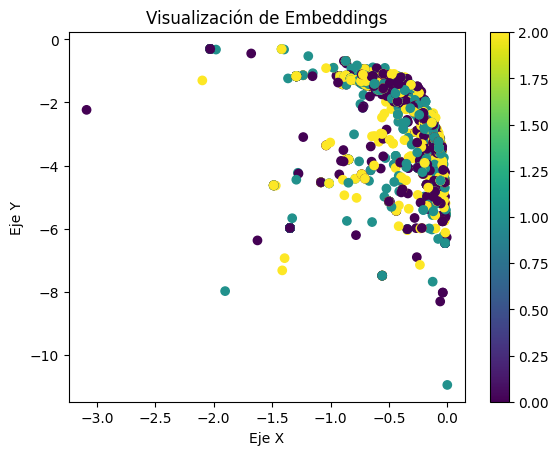

In [ ]:
import matplotlib.pyplot as plt

# Obtén los embeddings del modelo
model.eval()
embeddings = model(data).detach().cpu().numpy() # Replace 'dataset[0]' with 'data'
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=torch.randint(0,3,(data.num_nodes,)).cpu().numpy(), cmap='viridis') # I don't know what dataset[0].y is so I replaced it with random values. please put the correct code for dataset[0].y
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Visualización de Embeddings')
plt.colorbar()
plt.show()

# Visualización mediante t-SNE para reducir la dimensionalidad de los embeddings a 2 dimensiones

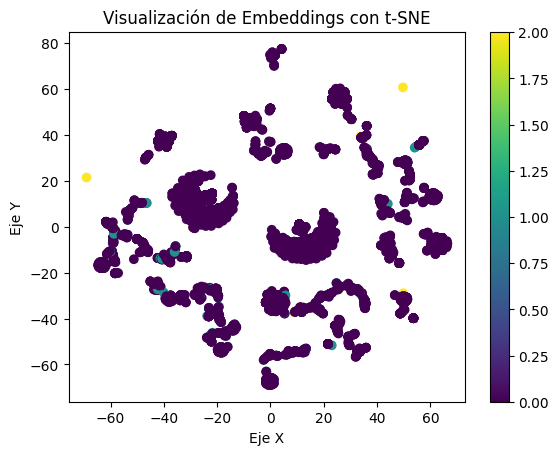

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd


# Reduce la dimensionalidad de los embeddings a 2 dimensiones
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Dibuja los embeddings
# **CHANGE:** Access the labels from the 'data' object
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y.cpu().numpy(), cmap='viridis')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Visualización de Embeddings con t-SNE')
plt.colorbar()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Epoch: 001, Loss: 0.3219, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 002, Loss: 0.2973, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 003, Loss: 0.2565, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 004, Loss: 0.2659, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 005, Loss: 0.2628, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 006, Loss: 0.2570, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 007, Loss: 0.3281, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 008, Loss: 0.2561, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 009, Loss: 0.2339, Train: 0.9812, Val: 0.9820, Test: 0.9784
Epoch: 010, Loss: 0.2869, Train: 0.9812, Val: 0.9820, Test: 0.9784
Final Test Accuracy: 0.9784


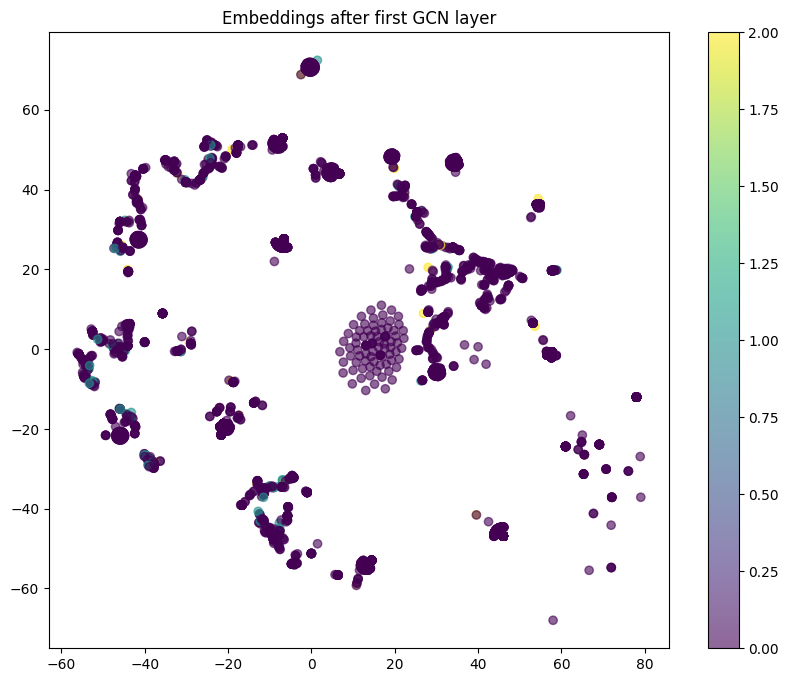

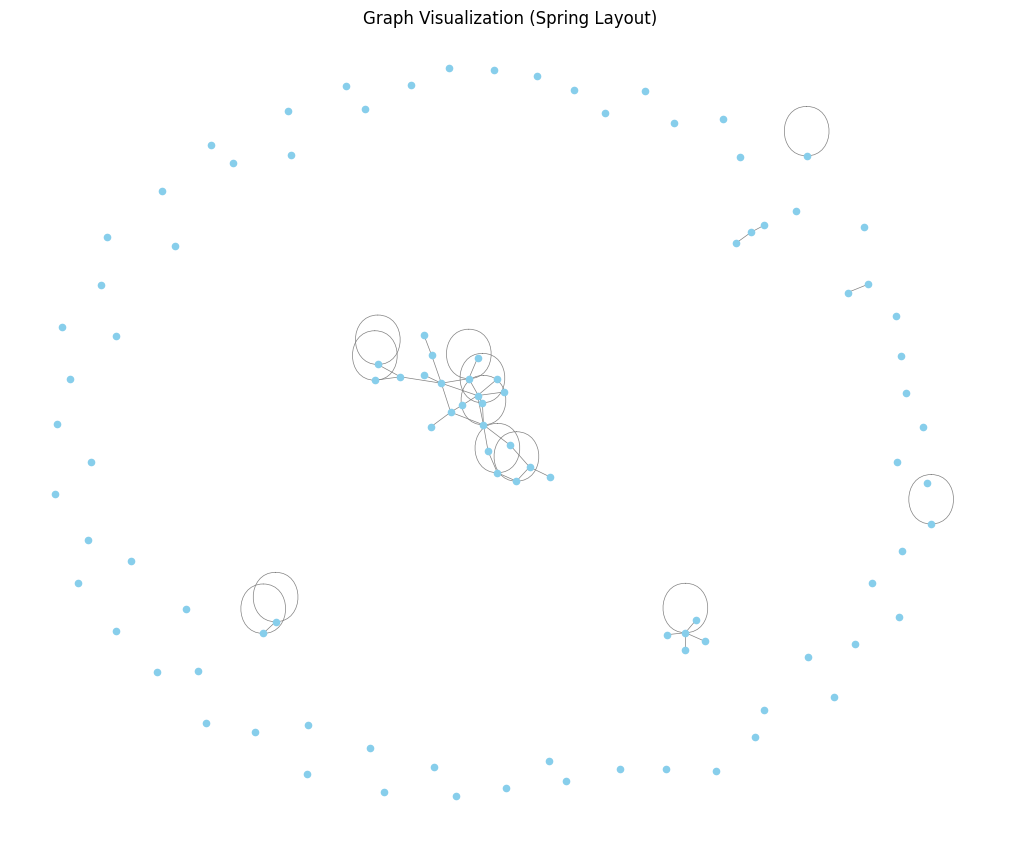

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from google.colab import drive

# 1. Carga y preprocesamiento de datos desde DataFrame
drive.mount('/content/drive')
dataset_df = pd.read_excel('/content/drive/MyDrive/Profundo/Retweets menas.xlsx')

source_col = 'Nombre de usuario'
target_col = 'Retwiteado por'
feature_cols = ['Cantidad de retweets', 'Cantidad de tweets', 'Cantidad de seguidores', 'Cantidad de Siguiendo']

dataset_df = dataset_df.dropna(subset=[source_col, target_col])
dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)

all_nodes = pd.unique(dataset_df[[source_col, target_col]].values.ravel('K'))
node_to_id = {node: i for i, node in enumerate(all_nodes)}

dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
dataset_df[target_col] = dataset_df[target_col].map(node_to_id)

edge_index = torch.tensor(dataset_df[[source_col, target_col]].values.T, dtype=torch.long)

assert edge_index.min() >= 0
assert edge_index.max() < len(all_nodes)

num_nodes = len(all_nodes)
x = torch.zeros((num_nodes, len(feature_cols)), dtype=torch.float)

for index, row in dataset_df.iterrows():
    node_id = row[source_col]
    feature_values = [float(val) for val in row[feature_cols].values]
    x[node_id] = torch.tensor(feature_values, dtype=torch.float)

x = (x - x.mean(dim=0)) / x.std(dim=0)

degrees = torch.zeros(num_nodes, dtype=torch.long)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1

y = torch.bucketize(degrees, boundaries=torch.tensor([5, 20]))
num_classes = len(torch.unique(y))

data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes
data.num_nodes = num_nodes

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

indices = torch.randperm(num_nodes)
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:train_end]] = True
data.val_mask[indices[train_end:val_end]] = True
data.test_mask[indices[val_end:]] = True

# 2. Definición del modelo
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Entrenamiento (primero en CPU)
device = torch.device('cpu')
print(f"Using device: {device}")

model = GCN(data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    if torch.isnan(out).any() or torch.isinf(out).any():
        print("NaN or Inf values detected in model output. Check your data or model.")
        return None
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

for epoch in range(1, 11):
    loss = train()
    if loss is None:
        continue
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

if torch.cuda.is_available():
    print("\nMoving to GPU...")
    device = torch.device('cuda')
    model = model.to(device)
    data = data.to(device)

    for epoch in range(11, 201):
        loss = train()
        if epoch % 20 == 0:
            train_acc, val_acc, test_acc = test()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = test_correct / data.test_mask.sum().item()
    print(f'Final Test Accuracy: {test_acc:.4f}')

def visualize_embeddings(embeddings, labels, title):
    embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

visualize_embeddings(embeddings, data.y.cpu().numpy(), 'Embeddings after first GCN layer')

def visualize_graph(graph, layout_func, title, ax=None):
    pos = layout_func(graph)
    nx.draw(graph, pos=pos, with_labels=False, node_size=20, node_color='skyblue', edge_color='gray', width=0.5, ax=ax)
    plt.title(title)

graph = to_networkx(data, to_undirected=True)
sampled_nodes = list(graph.nodes)[:100]
subgraph = graph.subgraph(sampled_nodes)

plt.figure(figsize=(10, 8))
visualize_graph(subgraph, nx.spring_layout, 'Graph Visualization (Spring Layout)')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-20-a6e75700aa9e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)
<ipython-input-20-a6e75700aa9e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
<ipython-input-20-a6e75700aa9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Using device: cpu
Epoch: 000, Loss: 0.6991, Train: 0.8624, Val: 0.8571, Test: 0.8587
Epoch: 020, Loss: 0.3292, Train: 0.9799, Val: 0.9856, Test: 0.9808
Epoch: 040, Loss: 0.2537, Train: 0.9799, Val: 0.9856, Test: 0.9808
Epoch: 060, Loss: 0.2632, Train: 0.9799, Val: 0.9856, Test: 0.9808
Epoch: 080, Loss: 0.1860, Train: 0.9799, Val: 0.9856, Test: 0.9808
Epoch: 100, Loss: 0.1775, Train: 0.9799, Val: 0.9856, Test: 0.9808
Epoch: 120, Loss: 0.1638, Train: 0.9799, Val: 0.9856, Test: 0.9808
Epoch: 140, Loss: 0.1468, Train: 0.9799, Val: 0.9856, Test: 0.9808
Epoch: 160, Loss: 0.1385, Train: 0.9799, Val: 0.9856, Test: 0.9808
Epoch: 180, Loss: 0.1385, Train: 0.9799, Val: 0.9856, Test: 0.9808
Final Test Accuracy: 0.9808


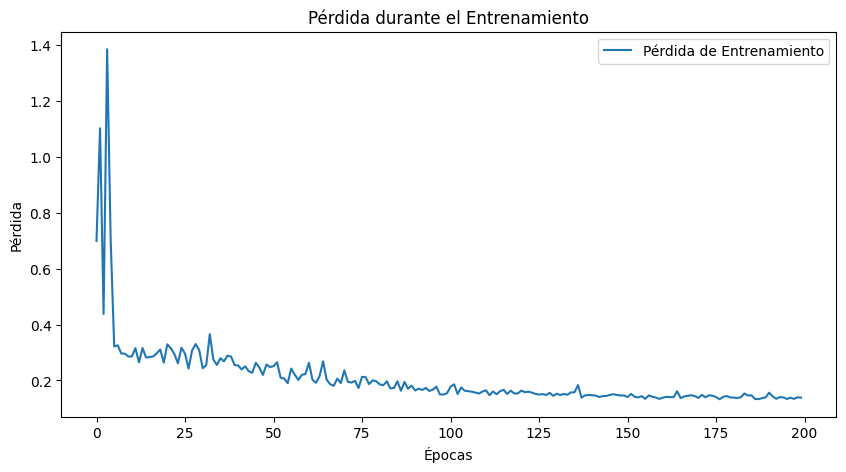

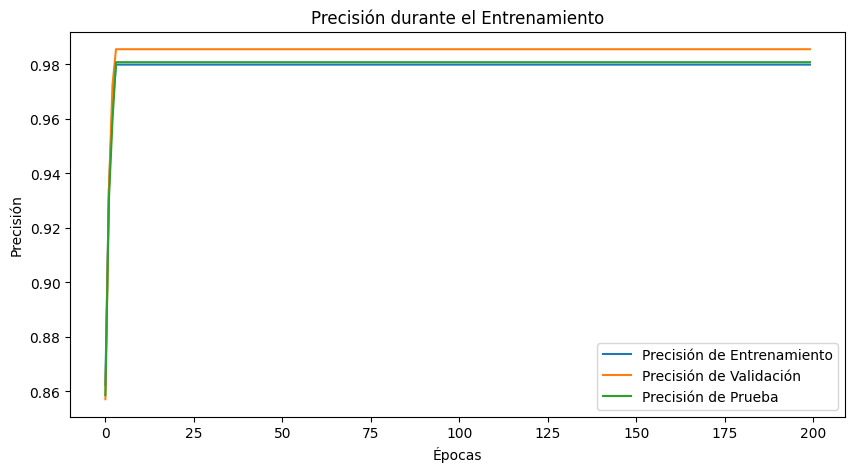

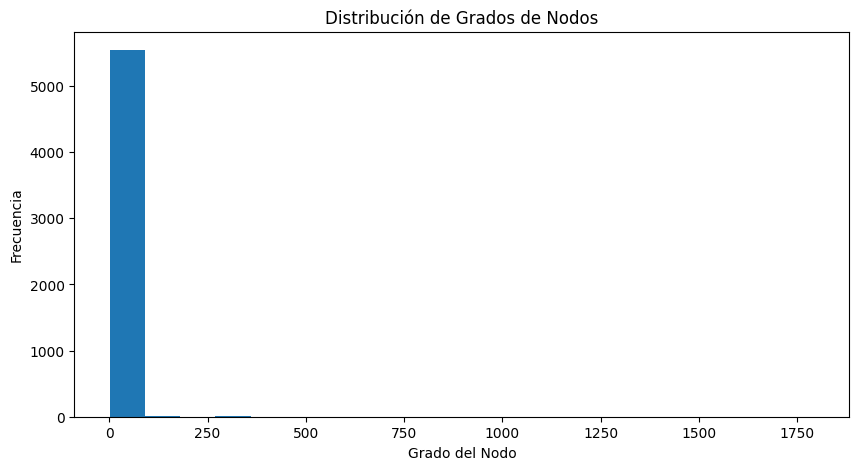

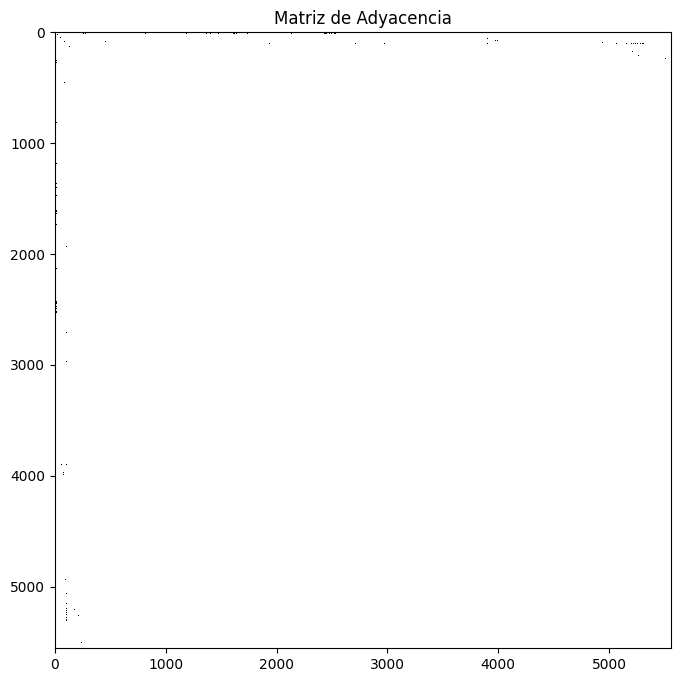

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, roc_auc_score, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from google.colab import drive

# 1. Carga y preprocesamiento de datos desde DataFrame
drive.mount('/content/drive')
dataset_df = pd.read_excel('/content/drive/MyDrive/Profundo/Retweets menas.xlsx')

source_col = 'Nombre de usuario'
target_col = 'Retwiteado por'
feature_cols = ['Cantidad de retweets', 'Cantidad de tweets', 'Cantidad de seguidores', 'Cantidad de Siguiendo']

dataset_df = dataset_df.dropna(subset=[source_col, target_col])
dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)

all_nodes = pd.unique(dataset_df[[source_col, target_col]].values.ravel('K'))
node_to_id = {node: i for i, node in enumerate(all_nodes)}

dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
dataset_df[target_col] = dataset_df[target_col].map(node_to_id)

edge_index = torch.tensor(dataset_df[[source_col, target_col]].values.T, dtype=torch.long)

assert edge_index.min() >= 0
assert edge_index.max() < len(all_nodes)

num_nodes = len(all_nodes)
x = torch.zeros((num_nodes, len(feature_cols)), dtype=torch.float)

for index, row in dataset_df.iterrows():
    node_id = row[source_col]
    feature_values = [float(val) for val in row[feature_cols].values]
    x[node_id] = torch.tensor(feature_values, dtype=torch.float)

x = (x - x.mean(dim=0)) / x.std(dim=0)

degrees = torch.zeros(num_nodes, dtype=torch.long)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1

y = torch.bucketize(degrees, boundaries=torch.tensor([5, 20]))
num_classes = len(torch.unique(y))

data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes
data.num_nodes = num_nodes

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

indices = torch.randperm(num_nodes)
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:train_end]] = True
data.val_mask[indices[train_end:val_end]] = True
data.test_mask[indices[val_end:]] = True

# 2. Definición del modelo
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Entrenamiento (primero en CPU)
device = torch.device('cpu')
print(f"Using device: {device}")

model = GCN(data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    if torch.isnan(out).any() or torch.isinf(out).any():
        print("NaN or Inf values detected in model output. Check your data or model.")
        return None
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

losses = []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(200):
    loss = train()
    if loss is None:
        continue
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = test_correct / data.test_mask.sum().item()
    print(f'Final Test Accuracy: {test_acc:.4f}')

# Gráficas
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Pérdida de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida durante el Entrenamiento')
    plt.legend()
    plt.show()

def plot_accuracy(train_accs, val_accs, test_accs):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Precisión de Entrenamiento')
    plt.plot(val_accs, label='Precisión de Validación')
    plt.plot(test_accs, label='Precisión de Prueba')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Precisión durante el Entrenamiento')
    plt.legend()
    plt.show()

def plot_degree_distribution(grafo):
    degrees = [grafo.degree(node) for node in grafo.nodes()]
    plt.figure(figsize=(10, 5))
    plt.hist(degrees, bins=20)
    plt.xlabel('Grado del Nodo')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Grados de Nodos')
    plt.show()

def plot_adjacency_matrix(grafo):
    adj_matrix = nx.to_numpy_array(grafo)
    plt.figure(figsize=(8, 8))
    plt.imshow(adj_matrix, cmap='binary', interpolation='none')
    plt.title('Matriz de Adyacencia')
    plt.show()

# Graficas
plot_loss(losses)
plot_accuracy(train_accs, val_accs, test_accs)
graph = to_networkx(data, to_undirected=True)
plot_degree_distribution(graph)
plot_adjacency_matrix(graph)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Epoch: 000, Loss: 2.5826, Train: 0.1522, Val: 0.1753, Test: 0.1641
Epoch: 020, Loss: 0.2280, Train: 0.9817, Val: 0.9796, Test: 0.9784
Epoch: 040, Loss: 0.2653, Train: 0.9817, Val: 0.9796, Test: 0.9784
Epoch: 060, Loss: 0.1773, Train: 0.9817, Val: 0.9796, Test: 0.9784
Epoch: 080, Loss: 0.1689, Train: 0.9817, Val: 0.9796, Test: 0.9784
Epoch: 100, Loss: 0.1719, Train: 0.9817, Val: 0.9796, Test: 0.9784
Epoch: 120, Loss: 0.1622, Train: 0.9817, Val: 0.9796, Test: 0.9784
Epoch: 140, Loss: 0.1774, Train: 0.9817, Val: 0.9796, Test: 0.9784
Epoch: 160, Loss: 0.1488, Train: 0.9817, Val: 0.9796, Test: 0.9784
Epoch: 180, Loss: 0.1499, Train: 0.9817, Val: 0.9796, Test: 0.9784
Final Test Accuracy: 0.9784


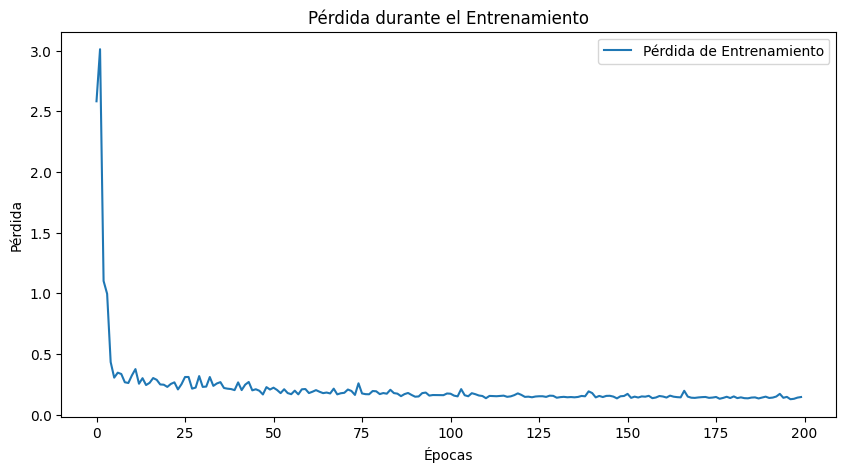

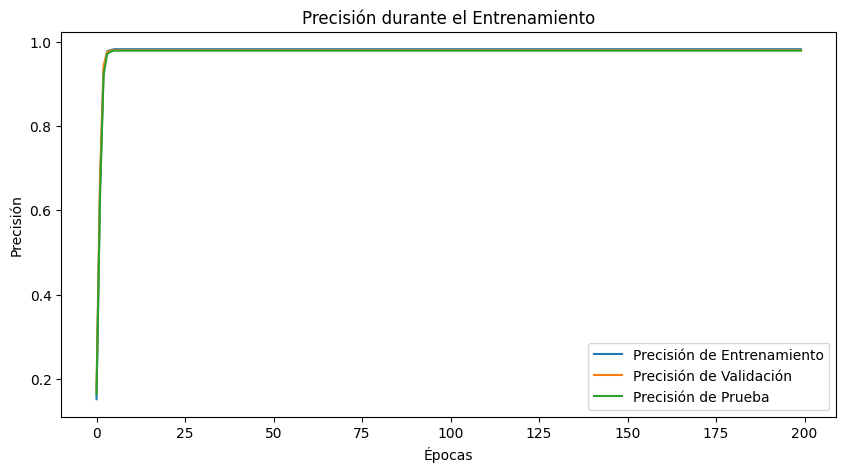

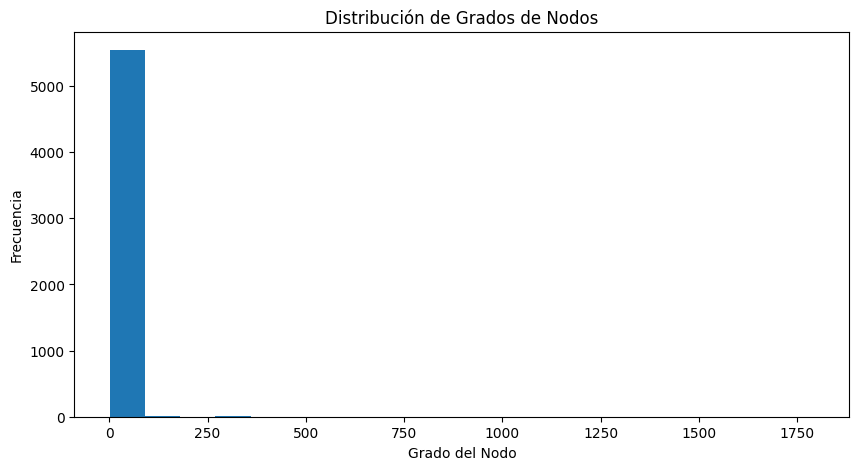

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, roc_auc_score, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from google.colab import drive

# 1. Carga y preprocesamiento de datos desde DataFrame
drive.mount('/content/drive')
dataset_df = pd.read_excel('/content/drive/MyDrive/Profundo/Retweets menas.xlsx')

source_col = 'Nombre de usuario'
target_col = 'Retwiteado por'
feature_cols = ['Cantidad de retweets', 'Cantidad de tweets', 'Cantidad de seguidores', 'Cantidad de Siguiendo']

dataset_df = dataset_df.dropna(subset=[source_col, target_col])
dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)

all_nodes = pd.unique(dataset_df[[source_col, target_col]].values.ravel('K'))
node_to_id = {node: i for i, node in enumerate(all_nodes)}

dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
dataset_df[target_col] = dataset_df[target_col].map(node_to_id)

edge_index = torch.tensor(dataset_df[[source_col, target_col]].values.T, dtype=torch.long)

assert edge_index.min() >= 0
assert edge_index.max() < len(all_nodes)

num_nodes = len(all_nodes)
x = torch.zeros((num_nodes, len(feature_cols)), dtype=torch.float)

for index, row in dataset_df.iterrows():
    node_id = row[source_col]
    feature_values = [float(val) for val in row[feature_cols].values]
    x[node_id] = torch.tensor(feature_values, dtype=torch.float)

x = (x - x.mean(dim=0)) / x.std(dim=0)

degrees = torch.zeros(num_nodes, dtype=torch.long)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1

y = torch.bucketize(degrees, boundaries=torch.tensor([5, 20]))
num_classes = len(torch.unique(y))

data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes
data.num_nodes = num_nodes

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

indices = torch.randperm(num_nodes)
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:train_end]] = True
data.val_mask[indices[train_end:val_end]] = True
data.test_mask[indices[val_end:]] = True

# 2. Definición del modelo
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Entrenamiento (primero en CPU)
device = torch.device('cpu')
print(f"Using device: {device}")

model = GCN(data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    if torch.isnan(out).any() or torch.isinf(out).any():
        print("NaN or Inf values detected in model output. Check your data or model.")
        return None
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

losses = []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(200):
    loss = train()
    if loss is None:
        continue
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = test_correct / data.test_mask.sum().item()
    print(f'Final Test Accuracy: {test_acc:.4f}')

# Gráficas
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Pérdida de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida durante el Entrenamiento')
    plt.legend()
    plt.show()

def plot_accuracy(train_accs, val_accs, test_accs):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Precisión de Entrenamiento')
    plt.plot(val_accs, label='Precisión de Validación')
    plt.plot(test_accs, label='Precisión de Prueba')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Precisión durante el Entrenamiento')
    plt.legend()
    plt.show()

def plot_degree_distribution(grafo):
    degrees = [grafo.degree(node) for node in grafo.nodes()]
    plt.figure(figsize=(10, 5))
    plt.hist(degrees, bins=20)
    plt.xlabel('Grado del Nodo')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Grados de Nodos')
    plt.show()

def plot_adjacency_matrix(grafo):
    adj_matrix = nx.to_numpy_array(grafo)
    plt.figure(figsize=(8, 8))
    plt.imshow(adj_matrix, cmap='binary', interpolation='none')
    plt.title('Matriz de Adyacencia')
    plt.show()

# Graficas
plot_loss(losses)
plot_accuracy(train_accs, val_accs, test_accs)
graph = to_networkx(data, to_undirected=True)
plot_degree_distribution(graph)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Epoch: 000, Loss: 11.5230, Train: 0.0203, Val: 0.0156, Test: 0.0132
Epoch: 020, Loss: 0.6861, Train: 0.8673, Val: 0.8788, Test: 0.8611
Epoch: 040, Loss: 0.3006, Train: 0.9802, Val: 0.9844, Test: 0.9808
Epoch: 060, Loss: 0.1954, Train: 0.9802, Val: 0.9844, Test: 0.9808
Epoch: 080, Loss: 0.2189, Train: 0.9802, Val: 0.9844, Test: 0.9808
Epoch: 100, Loss: 0.1979, Train: 0.9802, Val: 0.9844, Test: 0.9808
Epoch: 120, Loss: 0.1893, Train: 0.9802, Val: 0.9844, Test: 0.9808
Epoch: 140, Loss: 0.1946, Train: 0.9802, Val: 0.9844, Test: 0.9808
Epoch: 160, Loss: 0.1817, Train: 0.9802, Val: 0.9844, Test: 0.9808
Epoch: 180, Loss: 0.1611, Train: 0.9802, Val: 0.9844, Test: 0.9808
Final Test Accuracy: 0.9808


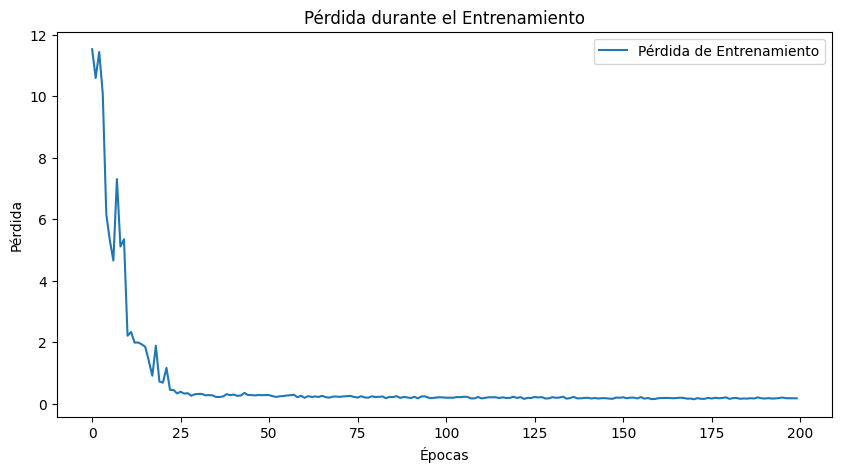

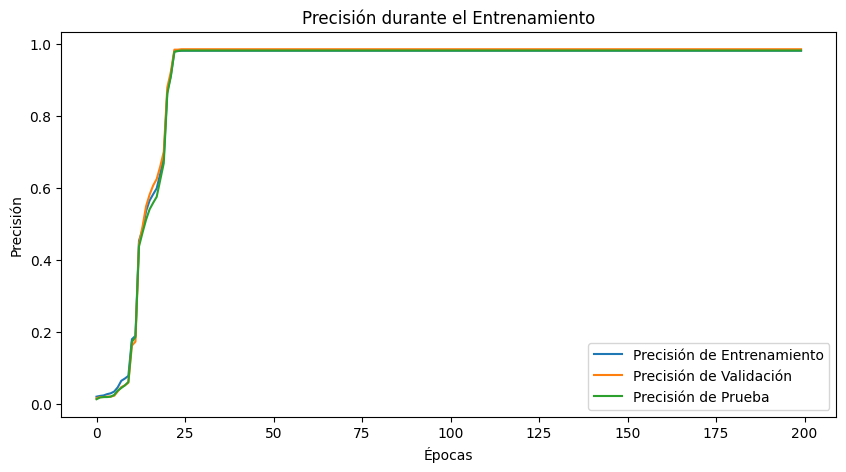

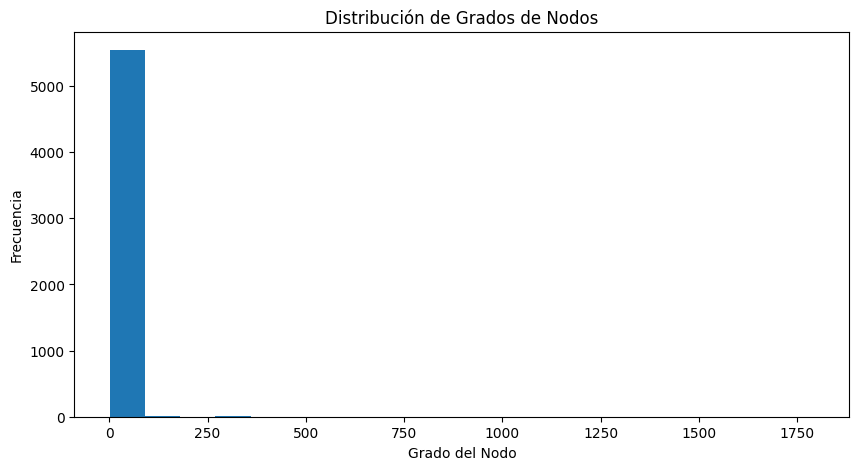

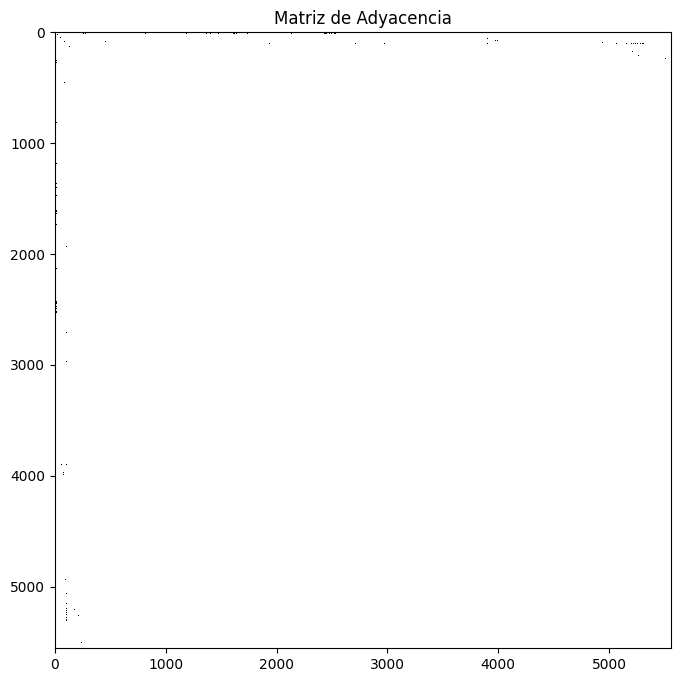

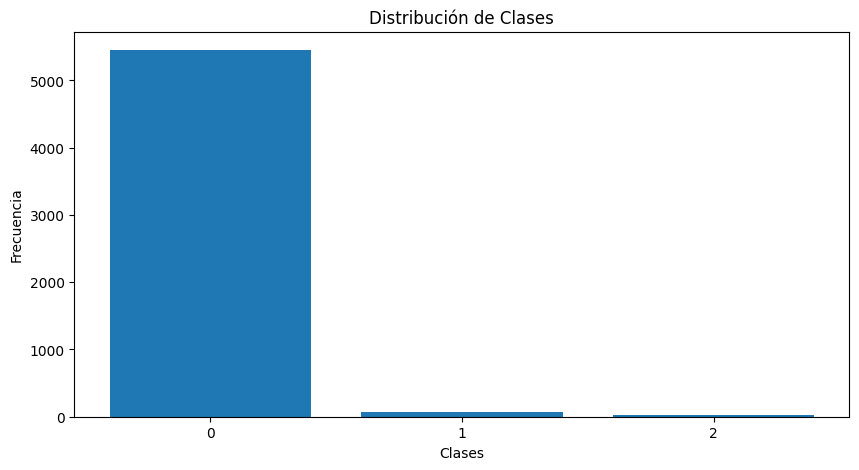

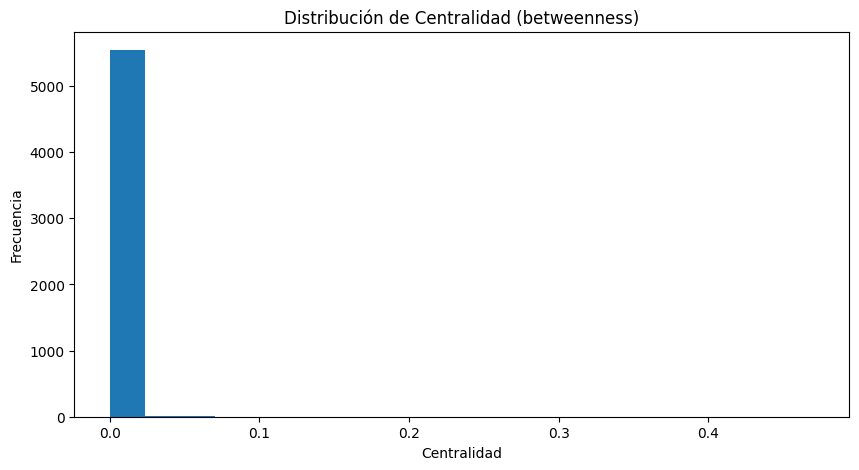

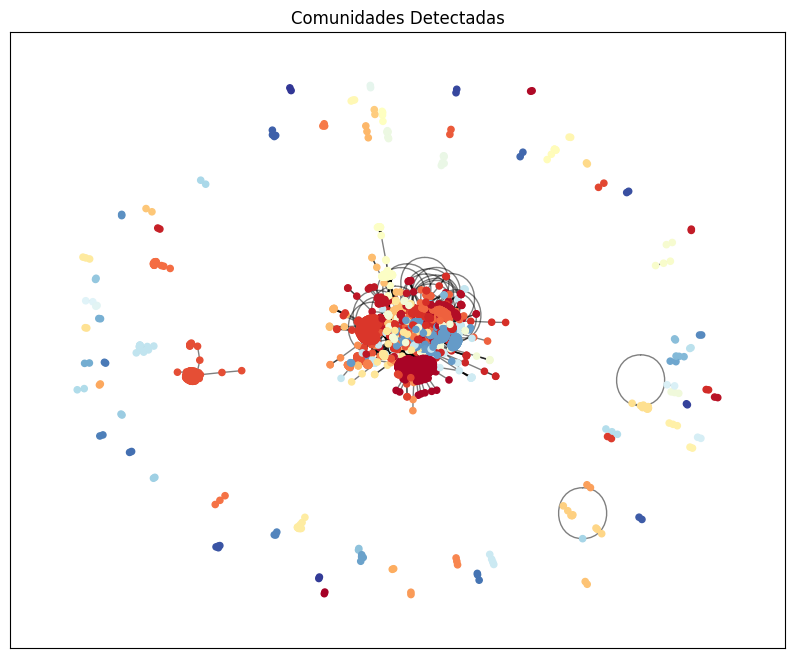

La densidad del grafo es: 0.0004612191758868396


In [ ]:
!pip install python-louvain
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, roc_auc_score, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from google.colab import drive
from community import community_louvain

# 1. Carga y preprocesamiento de datos desde DataFrame
drive.mount('/content/drive')
dataset_df = pd.read_excel('/content/drive/MyDrive/Profundo/Retweets menas.xlsx')

source_col = 'Nombre de usuario'
target_col = 'Retwiteado por'
feature_cols = ['Cantidad de retweets', 'Cantidad de tweets', 'Cantidad de seguidores', 'Cantidad de Siguiendo']

dataset_df = dataset_df.dropna(subset=[source_col, target_col])
dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)

all_nodes = pd.unique(dataset_df[[source_col, target_col]].values.ravel('K'))
node_to_id = {node: i for i, node in enumerate(all_nodes)}

dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
dataset_df[target_col] = dataset_df[target_col].map(node_to_id)

edge_index = torch.tensor(dataset_df[[source_col, target_col]].values.T, dtype=torch.long)

assert edge_index.min() >= 0
assert edge_index.max() < len(all_nodes)

num_nodes = len(all_nodes)
x = torch.zeros((num_nodes, len(feature_cols)), dtype=torch.float)

for index, row in dataset_df.iterrows():
    node_id = row[source_col]
    feature_values = [float(val) for val in row[feature_cols].values]
    x[node_id] = torch.tensor(feature_values, dtype=torch.float)

x = (x - x.mean(dim=0)) / x.std(dim=0)

degrees = torch.zeros(num_nodes, dtype=torch.long)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1

y = torch.bucketize(degrees, boundaries=torch.tensor([5, 20]))
num_classes = len(torch.unique(y))

data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes
data.num_nodes = num_nodes

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

indices = torch.randperm(num_nodes)
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:train_end]] = True
data.val_mask[indices[train_end:val_end]] = True
data.test_mask[indices[val_end:]] = True

# 2. Definición del modelo
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Entrenamiento (primero en CPU)
device = torch.device('cpu')
print(f"Using device: {device}")

model = GCN(data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    if torch.isnan(out).any() or torch.isinf(out).any():
        print("NaN or Inf values detected in model output. Check your data or model.")
        return None
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

losses = []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(200):
    loss = train()
    if loss is None:
        continue
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = test_correct / data.test_mask.sum().item()
    print(f'Final Test Accuracy: {test_acc:.4f}')

# Gráficas
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Pérdida de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida durante el Entrenamiento')
    plt.legend()
    plt.show()

def plot_accuracy(train_accs, val_accs, test_accs):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Precisión de Entrenamiento')
    plt.plot(val_accs, label='Precisión de Validación')
    plt.plot(test_accs, label='Precisión de Prueba')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Precisión durante el Entrenamiento')
    plt.legend()
    plt.show()

def plot_degree_distribution(grafo):
    degrees = [grafo.degree(node) for node in grafo.nodes()]
    plt.figure(figsize=(10, 5))
    plt.hist(degrees, bins=20)
    plt.xlabel('Grado del Nodo')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Grados de Nodos')
    plt.show()

def plot_adjacency_matrix(grafo):
    adj_matrix = nx.to_numpy_array(grafo)
    plt.figure(figsize=(8, 8))
    plt.imshow(adj_matrix, cmap='binary', interpolation='none')
    plt.title('Matriz de Adyacencia')
    plt.show()

def plot_class_distribution(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique_labels, counts)
    plt.xlabel('Clases')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Clases')
    plt.xticks(unique_labels)
    plt.show()

def plot_centrality_distribution(grafo, centrality_measure='degree'):
    if centrality_measure == 'degree':
        centrality = nx.degree_centrality(grafo)
    elif centrality_measure == 'closeness':
        centrality = nx.closeness_centrality(grafo)
    elif centrality_measure == 'betweenness':
        centrality = nx.betweenness_centrality(grafo)
    else:
        raise ValueError("centrality_measure must be 'degree', 'closeness', or 'betweenness'")

    centrality_values = list(centrality.values())
    plt.figure(figsize=(10, 5))
    plt.hist(centrality_values, bins=20)
    plt.xlabel('Centralidad')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de Centralidad ({centrality_measure})')
    plt.show()

def plot_communities(grafo):
    # **CHANGE:** Call the function using the community_louvain object
    partition = community_louvain.best_partition(grafo)
    pos = nx.spring_layout(grafo)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(grafo, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
    nx.draw_networkx_edges(grafo, pos, alpha=0.5)
    plt.title('Comunidades Detectadas')
    plt.show()

# Graficas
plot_loss(losses)
plot_accuracy(train_accs, val_accs, test_accs)
graph = to_networkx(data, to_undirected=True)
plot_degree_distribution(graph)
plot_adjacency_matrix(graph)
plot_class_distribution(data.y.cpu().numpy())
plot_centrality_distribution(graph, centrality_measure='betweenness')
plot_communities(graph)

# verificar densidad del grafo.
density = nx.density(graph)
print(f"La densidad del grafo es: {density}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Epoch: 000, Loss: 3.7569, Train: 0.4610, Val: 0.4898, Test: 0.4671
Epoch: 020, Loss: 0.4590, Train: 0.9787, Val: 0.9832, Test: 0.9892
Epoch: 040, Loss: 0.4050, Train: 0.9787, Val: 0.9832, Test: 0.9892
Epoch: 060, Loss: 0.2966, Train: 0.9787, Val: 0.9832, Test: 0.9892
Epoch: 080, Loss: 0.2437, Train: 0.9787, Val: 0.9832, Test: 0.9892
Epoch: 100, Loss: 0.2068, Train: 0.9787, Val: 0.9832, Test: 0.9892
Epoch: 120, Loss: 0.1819, Train: 0.9787, Val: 0.9832, Test: 0.9892
Epoch: 140, Loss: 0.1882, Train: 0.9787, Val: 0.9832, Test: 0.9892
Epoch: 160, Loss: 0.1582, Train: 0.9787, Val: 0.9832, Test: 0.9892
Epoch: 180, Loss: 0.1618, Train: 0.9787, Val: 0.9832, Test: 0.9892
Final Test Accuracy: 0.9892
Densidad del grafo: 0.0002
Coeficiente de clustering promedio: 0.0073

Número de Nodos: 5557
Número de Aristas: 7122

Características de las Aristas:
[(0, 

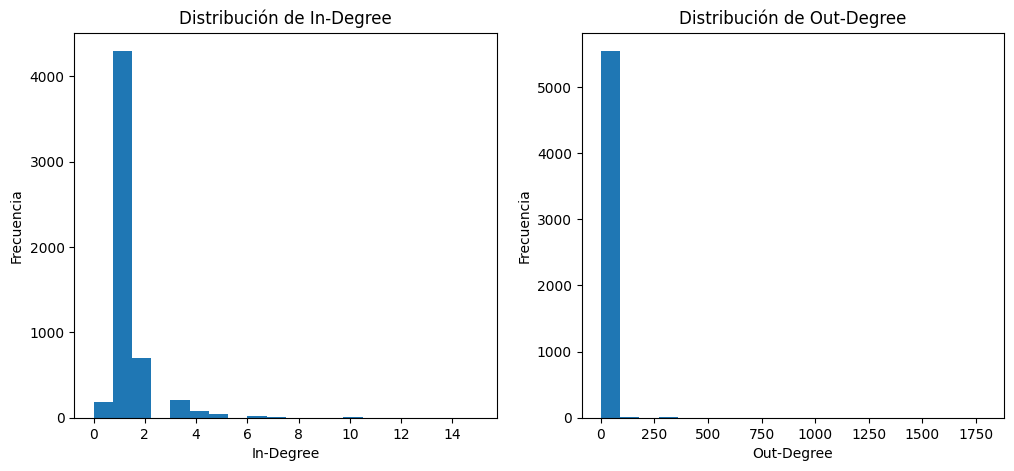

In [ ]:
!pip install python-louvain
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, roc_auc_score, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from google.colab import drive
from community import community_louvain

# 1. Carga y preprocesamiento de datos desde DataFrame
drive.mount('/content/drive')
dataset_df = pd.read_excel('/content/drive/MyDrive/Profundo/Retweets menas.xlsx')

source_col = 'Nombre de usuario'
target_col = 'Retwiteado por'
feature_cols = ['Cantidad de retweets', 'Cantidad de tweets', 'Cantidad de seguidores', 'Cantidad de Siguiendo']

dataset_df = dataset_df.dropna(subset=[source_col, target_col])
dataset_df[feature_cols] = dataset_df[feature_cols].fillna(0)

all_nodes = pd.unique(dataset_df[[source_col, target_col]].values.ravel('K'))
node_to_id = {node: i for i, node in enumerate(all_nodes)}

dataset_df[source_col] = dataset_df[source_col].map(node_to_id)
dataset_df[target_col] = dataset_df[target_col].map(node_to_id)

edge_index = torch.tensor(dataset_df[[source_col, target_col]].values.T, dtype=torch.long)

assert edge_index.min() >= 0
assert edge_index.max() < len(all_nodes)

num_nodes = len(all_nodes)
x = torch.zeros((num_nodes, len(feature_cols)), dtype=torch.float)

for index, row in dataset_df.iterrows():
    node_id = row[source_col]
    feature_values = [float(val) for val in row[feature_cols].values]
    x[node_id] = torch.tensor(feature_values, dtype=torch.float)

x = (x - x.mean(dim=0)) / x.std(dim=0)

degrees = torch.zeros(num_nodes, dtype=torch.long)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1

y = torch.bucketize(degrees, boundaries=torch.tensor([5, 20]))
num_classes = len(torch.unique(y))

data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes
data.num_nodes = num_nodes

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

indices = torch.randperm(num_nodes)
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:train_end]] = True
data.val_mask[indices[train_end:val_end]] = True
data.test_mask[indices[val_end:]] = True

# 2. Definición del modelo
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Entrenamiento (primero en CPU)
device = torch.device('cpu')
print(f"Using device: {device}")

model = GCN(data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    if torch.isnan(out).any() or torch.isinf(out).any():
        print("NaN or Inf values detected in model output. Check your data or model.")
        return None
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

losses = []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(200):
    loss = train()
    if loss is None:
        continue
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    test_acc = test_correct / data.test_mask.sum().item()
    print(f'Final Test Accuracy: {test_acc:.4f}')

# Gráficas
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Pérdida de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida durante el Entrenamiento')
    plt.legend()
    plt.show()

def plot_accuracy(train_accs, val_accs, test_accs):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Precisión de Entrenamiento')
    plt.plot(val_accs, label='Precisión de Validación')
    plt.plot(test_accs, label='Precisión de Prueba')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Precisión durante el Entrenamiento')
    plt.legend()
    plt.show()

def plot_degree_distribution(grafo):
    degrees = [grafo.degree(node) for node in grafo.nodes()]
    plt.figure(figsize=(10, 5))
    plt.hist(degrees, bins=20)
    plt.xlabel('Grado del Nodo')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Grados de Nodos')
    plt.show()

def plot_adjacency_matrix(grafo):
    adj_matrix = nx.to_numpy_array(grafo)
    plt.figure(figsize=(8, 8))
    plt.imshow(adj_matrix, cmap='binary', interpolation='none')
    plt.title('Matriz de Adyacencia')
    plt.show()

def plot_class_distribution(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique_labels, counts)
    plt.xlabel('Clases')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Clases')
    plt.xticks(unique_labels)
    plt.show()

def plot_centrality_distribution(grafo, centrality_measure='degree'):
    if centrality_measure == 'degree':
        centrality = nx.degree_centrality(grafo)
    elif centrality_measure == 'closeness':
        centrality = nx.closeness_centrality(grafo)
    elif centrality_measure == 'betweenness':
        centrality = nx.betweenness_centrality(grafo)
    else:
        raise ValueError("centrality_measure must be 'degree', 'closeness', or 'betweenness'")

    centrality_values = list(centrality.values())
    plt.figure(figsize=(10, 5))
    plt.hist(centrality_values, bins=20)
    plt.xlabel('Centralidad')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de Centralidad ({centrality_measure})')
    plt.show()

def calculate_graph_metrics(grafo):
    """Calcula y muestra métricas de grafos."""

    # Densidad
    density = nx.density(grafo)
    print(f"Densidad del grafo: {density:.4f}")


    # Coeficiente de clustering promedio
    avg_clustering = nx.average_clustering(grafo)
    print(f"Coeficiente de clustering promedio: {avg_clustering:.4f}")



calculate_graph_metrics(graph)

# Cuantificación de Nodos y Aristas
print(f"\nNúmero de Nodos: {graph.number_of_nodes()}")
print(f"Número de Aristas: {graph.number_of_edges()}")

# Características de las Aristas
edge_attrs = {}
for u, v in graph.edges():
  edge_attrs[(u,v)] = {'weight': 1} # Puedes agregar más atributos aquí.
nx.set_edge_attributes(graph, edge_attrs)
print("\nCaracterísticas de las Aristas:")
print(graph.edges(data=True))

def calculate_graph_metrics(grafo):
    """Calcula y muestra métricas de grafos."""

    # Densidad
    density = nx.density(grafo)
    print(f"Densidad del grafo: {density:.4f}")

    # Diámetro - Modificado para grafos dirigidos
    # if nx.is_connected(grafo):  # Esto solo funciona para grafos no dirigidos
    #     diameter = nx.diameter(grafo)
    #     print(f"Diámetro del grafo: {diameter}")
    # else:
    #     print("El grafo no está conectado, no se puede calcular el diámetro.")

    # Para grafos dirigidos, podemos usar:
    try:
        diameter = nx.diameter(grafo.to_undirected())  # Convertir a no dirigido para el diámetro
        print(f"Diámetro del grafo (no dirigido): {diameter}")
    except nx.NetworkXError:
        print("El grafo dirigido no está fuertemente conectado, no se puede calcular el diámetro.")


    # Coeficiente de clustering promedio
    avg_clustering = nx.average_clustering(grafo)
    print(f"Coeficiente de clustering promedio: {avg_clustering:.4f}")

    # Modularidad
    # Asegúrate de que 'grafo' sea no dirigido para la modularidad
    partition = community_louvain.best_partition(grafo.to_undirected())
    modularity = community_louvain.modularity(partition, grafo.to_undirected())
    print(f"\nModularidad: {modularity:.4f}")

    # Visualización de la modularidad
    pos = nx.spring_layout(grafo)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(grafo, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
    nx.draw_networkx_edges(grafo, pos, alpha=0.5)
    plt.title('Comunidades Detectadas (Modularidad)')
    plt.show()

# Métricas de Aristas
def edge_metrics(grafo):
  in_degrees = grafo.in_degree()
  out_degrees = grafo.out_degree()
  print("\nIn-Degree de las Aristas:")
  print(in_degrees)
  print("\nOut-Degree de las Aristas:")
  print(out_degrees)

edge_metrics(graph)

# Gráficas de Aristas
def edge_degree_distribution(grafo):
  in_degrees = [d for n, d in grafo.in_degree()]
  out_degrees = [d for n, d in grafo.out_degree()]

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.hist(in_degrees, bins=20)
  plt.xlabel('In-Degree')
  plt.ylabel('Frecuencia')
  plt.title('Distribución de In-Degree')

  plt.subplot(1, 2, 2)
  plt.hist(out_degrees, bins=20)
  plt.xlabel('Out-Degree')
  plt.ylabel('Frecuencia')
  plt.title('Distribución de Out-Degree')

  plt.show()

edge_degree_distribution(graph)